# **Tarea 2: Principal Component Analysis, Neural Networks**

Integrantes de equipo de trabajo:
- Calle Ontaneda, Hugo Jazyel
- Chero Villegas, Leidy Fabiola
- Cueva Mendoza, Jherson Aldair.

## **Part I: Eigenfaces for Face Recognition**


In [1]:
# Importamos y montamos Google Drive para acceder a la carpeta 'data'
from google.colab import drive
drive.mount('/content/drive')

# Definimos la ruta base donde se encuentra la carpeta 'data'
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/ENEI/Machine Learning II/ENEI-2025-ML2-Tarea2-main/data"

# Verificamos que existan los archivos listados en 'data'
!ls -la "$BASE_PATH"

Mounted at /content/drive
total 25
drwx------ 2 root root  4096 Nov  3 21:22 faces
-rw------- 1 root root  3310 Oct 28 13:17 test.txt
-rw------- 1 root root 17874 Oct 28 13:17 train.txt


### 1. **Load the Training and Test Sets**

- Load the training images contained in `data` into a matrix **X**. There are 540 training images, each with resolution $50 \times 50$. Flatten each image into a 2500-dimensional vector. Thus, **X** should have shape $540 \times 2500$, where each row is a flattened face image.

In [2]:
# Importamos las librerías necesarias
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import imageio

# Cargamos las imágenes de entrenamiento y sus etiquetas
train_labels, train_data = [], []

# Leemos cada línea de train.txt (cada línea tiene: "ruta etiqueta")
with open(f"{BASE_PATH}/train.txt", "r") as f:
    for line in f:
        path, label = line.strip().split()
        # Leemos la imagen (50x50) desde la ruta relativa dentro de 'data'
        img = imageio.v2.imread(f"{BASE_PATH}/{path}")
        # Aplanamos la imagen 50x50 → vector de 2500
        train_data.append(img.reshape(2500,))
        # Convertimos la etiqueta a entero
        train_labels.append(int(label))

# Convertimos a arreglos NumPy con dtypes adecuados
X_train = np.array(train_data, dtype=float)
y_train = np.array(train_labels, dtype=int)

# Verificamos las formas solicitadas
print("X_train shape:", X_train.shape)  # Esperado: (540, 2500)
print("y_train shape:", y_train.shape)  # Esperado: (540,)

X_train shape: (540, 2500)
y_train shape: (540,)


- Similarly, build the test matrix $X_{test}$, which should have shape $100 \times 2500$.

In [3]:
# Cargamos las imágenes de prueba y sus etiquetas
test_labels, test_data = [], []

# Leemos cada línea de test.txt (cada línea tiene: "ruta etiqueta")
with open(f"{BASE_PATH}/test.txt", "r") as f:
    for line in f:
        path, label = line.strip().split()
        # Leemos la imagen (50x50)
        img = imageio.v2.imread(f"{BASE_PATH}/{path}")
        # Aplanamos a vector de 2500
        test_data.append(img.reshape(2500,))
        # Convertimos la etiqueta a entero
        test_labels.append(int(label))

# Convertimos a arreglos NumPy
X_test = np.array(test_data, dtype=float)
y_test = np.array(test_labels, dtype=int)

# Verificamos las formas solicitadas
print("X_test shape:", X_test.shape)  # Esperado: (100, 2500)
print("y_test shape:", y_test.shape)  # Esperado: (100,)

X_test shape: (100, 2500)
y_test shape: (100,)


- Display an example training and test image in grayscale.

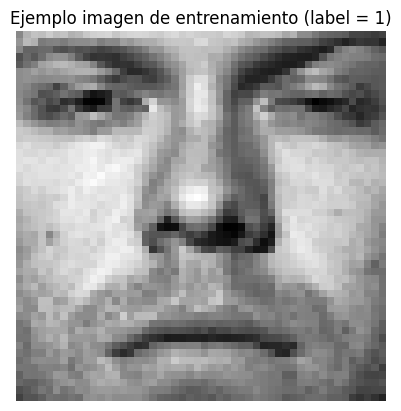

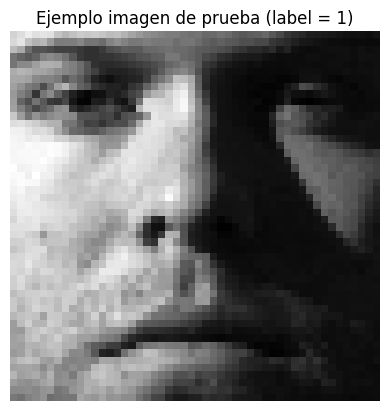

In [4]:
# Mostramos un ejemplo de imagen de entrenamiento en escala de grises
plt.imshow(X_train[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title(f"Ejemplo imagen de entrenamiento (label = {y_train[10]})")
plt.axis('off')
plt.show()

# Mostramos un ejemplo de imagen de prueba en escala de grises
plt.imshow(X_test[5, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title(f"Ejemplo imagen de prueba (label = {y_test[5]})")
plt.axis('off')
plt.show()

### 2. **Average Face**

- Compute the average face vector $\mu$ by averaging all rows of **X**. Display this average face as a grayscale image.

mu shape: (2500,)
mu dtype: float64


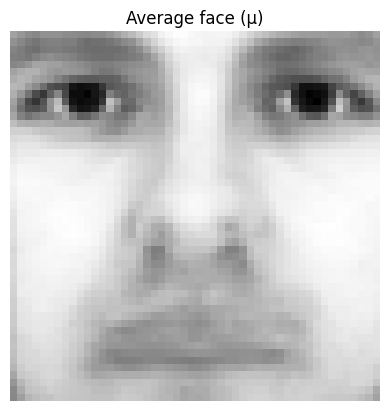

In [5]:
# Calculamos el rostro promedio μ promediando filas de X_train
mu = X_train.mean(axis=0)     # Vector de 2500

# Verificamos dimensiones y tipo
print("mu shape:", mu.shape)  # Esperado: (2500,)
print("mu dtype:", mu.dtype)

# Mostramos μ como imagen 50x50 en escala de grises
plt.imshow(mu.reshape(50, 50), cmap=cm.Greys_r)
plt.title("Average face (μ)")
plt.axis('off')
plt.show()

### 3. **Mean Subtraction**

- Subtract the average face $\mu$ from each row of **X**, i.e., replace each image vector $x_i$ with $x_i - \mu$. Display an example mean-subtracted image. Apply the same mean subtraction to $X_{test}$, using the same $\mu$. From now on, for training and testing, you should use the demeaned matrix.

In [6]:
# Restamos el rostro promedio μ a cada imagen de entrenamiento
X_train_demeaned = X_train - mu

# Mostramos las nuevas dimensiones y verificamos resultado para X_train_demeaned
print("X_train_demeaned shape:", X_train_demeaned.shape) # Esperado: (540, 2500)

X_train_demeaned shape: (540, 2500)


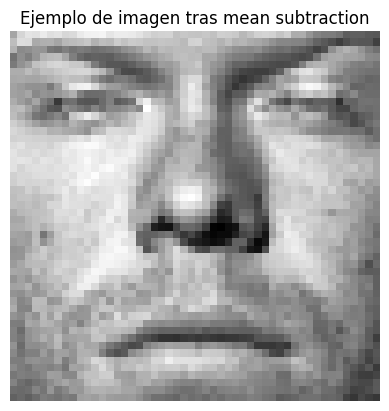

In [7]:
# Mostramos un ejemplo de imagen centrada (mean-subtracted)
plt.imshow(X_train_demeaned[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title("Ejemplo de imagen tras mean subtraction")
plt.axis('off')
plt.show()

In [8]:
# Restamos la misma μ a las imágenes de prueba
X_test_demeaned = X_test - mu

# Mostramos las nuevas dimensiones para X_test_demeaned
print("X_test_demeaned shape:", X_test_demeaned.shape)   # Esperado: (100, 2500)

X_test_demeaned shape: (100, 2500)


### 4. **Eigenfaces**

- Compute the eigendecomposition of $X^T X = V \Lambda V^T$ to obtain eigenvectors. The rows of $V^T$ correspond to eigenfaces.

In [9]:
# Calculamos la matriz X^T X usando los datos de entrenamiento centrados
XtX = X_train_demeaned.T @ X_train_demeaned  # Matriz 2500x2500 (simétrica y semidefinida positiva)

# Obtenemos autovalores (w) y autovectores (V) de X^T X
# Usamos eigh porque XtX es simétrica, lo que garantiza autovalores reales
w, V = np.linalg.eigh(XtX)

# Ordenamos los autovalores y autovectores en orden descendente
idx = np.argsort(w)[::-1]
w = w[idx]
V = V[:, idx]  # Cada columna de V es un eigenvector (una eigenface)

# Verificamos las dimensiones
print("XtX shape:", XtX.shape)   # Esperado: (2500, 2500)
print("V shape:", V.shape)       # Esperado: (2500, 2500)
print("w shape:", w.shape)       # Esperado: (2500,)

XtX shape: (2500, 2500)
V shape: (2500, 2500)
w shape: (2500,)


- Display 10 eigenfaces as grayscale images. Note: Eigenvectors may be complex-valued. You will need to convert them to real values before displaying (e.g., using `np.real`).

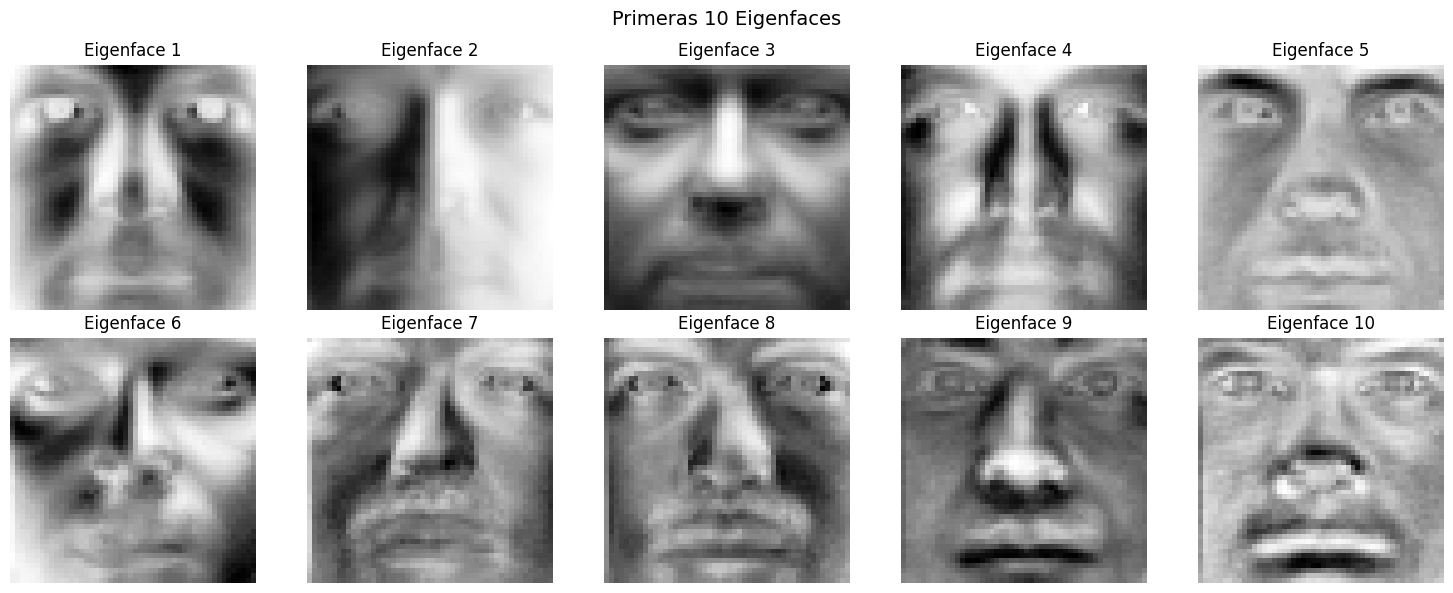

In [10]:
# Mostramos las primeras 10 eigenfaces (autovectores principales)
n_show = 10

plt.figure(figsize=(15, 6))
for i in range(n_show):
    # Extraemos la i-ésima eigenface (columna i de V)
    ef = np.real(V[:, i])  # Nos aseguramos de que sea real

    # Reescalamos a [0,1] para mejorar el contraste visual
    ef_min, ef_max = ef.min(), ef.max()
    ef_vis = (ef - ef_min) / (ef_max - ef_min + 1e-12)

    # Graficamos la eigenface como imagen 50x50
    plt.subplot(2, 5, i + 1)
    plt.imshow(ef_vis.reshape(50, 50), cmap=cm.Greys_r)
    plt.title(f"Eigenface {i+1}")
    plt.axis('off')

plt.suptitle("Primeras 10 Eigenfaces", fontsize=14)
plt.tight_layout()
plt.show()

# Nota: los autovectores pueden tener pequeñas partes imaginarias;
# por ello usamos np.real(V[:, i]) antes de graficar, tal como sugiere el enunciado.

En PCA, la matriz que se diagonaliza ($X^\top X$ o la matriz de covarianza) es simétrica y real, lo que garantiza que sus autovalores sean reales y sus autovectores ortogonales.

Por esta razón se utiliza `np.linalg.eigh()`, ya que está especialmente diseñada para matrices simétricas o hermíticas, ofreciendo resultados numéricamente más estables y exactos. En cambio, `np.linalg.eig()` es un método más general que puede producir autovalores complejos o autovectores no ortogonales, lo cual no es apropiado en este contexto.

### 5. **Eigenface Features**

   The top $r$ eigenfaces span an $r$-dimensional **face space**.
   Represent an image vector $z$ in this space as:
   
$$
   f = [v_1, v_2, \ldots, v_r]^T z
$$

   Write a function to compute:

   * **$F$**: feature matrix for training data (shape: $540 \times r$)
   * **$F_{test}$**: feature matrix for test data (shape: $100 \times r$)

   by multiplying **$X$** and **$X_{test}$** with the top $ r$ eigenfaces.

In [11]:
# Analizamos las primeras r eigenfaces que definen un subespacio
# de rostros de dimensión r. En este espacio, cada imagen puede
# representarse mediante una combinación lineal de estas eigenfaces.

def extraer_caracteristicas(X, V, r):
    """
    Proyectamos las imágenes centradas (demeaned) al subespacio
    de dimensión r usando las r primeras eigenfaces.
    Retorna la matriz de características F.
    """
    Vr = V[:, :r]          # Seleccionamos las r primeras eigenfaces
    F = X @ Vr             # Proyección al subespacio de rostros
    return F

# Implementamos un ejemplo inicial con r = 10
r = 10
F_train = extraer_caracteristicas(X_train_demeaned, V, r)
F_test  = extraer_caracteristicas(X_test_demeaned,  V, r)

print("Forma de F_train:", F_train.shape)
print("Forma de F_test :", F_test.shape)

Forma de F_train: (540, 10)
Forma de F_test : (100, 10)


### 6. **Face Recognition**

   Use **logistic regression** (e.g., from `scikit-learn`) for classification.

   * Extract features using $ r = 10 $ (supress the intercept, as it is not necessary because the matrix is demeaned)
   * Train logistic regression on **$F$** and evaluate on **$F_{test}$**
   * Report classification accuracy on the test set
   * Then repeat for $ r = 1, 2, \ldots, 200 $ and plot accuracy as a function of $ r $

In [12]:
# Implementamos un modelo de regresión logística para clasificar
# los rostros a partir de las características obtenidas (F_train).
# Evaluamos primero con r = 10 y luego variamos r en el rango 1–200.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Entrenamos con r = 10
modelo = LogisticRegression(fit_intercept=False, multi_class="ovr",
                            solver="lbfgs", max_iter=2000, random_state=42)
modelo.fit(F_train, y_train)
y_pred = modelo.predict(F_test)

acc_10 = accuracy_score(y_test, y_pred)
print(f"Exactitud en el conjunto de prueba (r=10): {acc_10:.4f}")

# Evaluamos la precisión variando r
rs = range(1, 201)
accuracies = []

for r in rs:
    F_train_r = extraer_caracteristicas(X_train_demeaned, V, r)
    F_test_r  = extraer_caracteristicas(X_test_demeaned,  V, r)

    modelo = LogisticRegression(fit_intercept=False, multi_class="ovr",
                                solver="lbfgs", max_iter=1500, random_state=42)
    modelo.fit(F_train_r, y_train)
    y_pred_r = modelo.predict(F_test_r)
    accuracies.append(accuracy_score(y_test, y_pred_r))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Exactitud en el conjunto de prueba (r=10): 0.5900


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

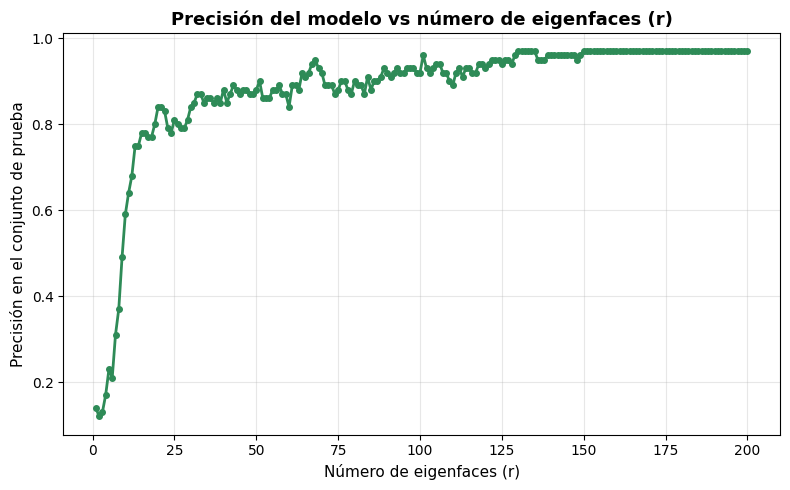

In [13]:
# Analizamos la variación de la precisión según r
# Graficamos
plt.figure(figsize=(8,5))
plt.plot(rs, accuracies, color='#2E8B57', linewidth=2, marker='o',
         markerfacecolor='#2E8B57', markersize=4)
plt.title("Precisión del modelo vs número de eigenfaces (r)", fontsize=13, fontweight='bold')
plt.xlabel("Número de eigenfaces (r)", fontsize=11)
plt.ylabel("Precisión en el conjunto de prueba", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Identificamos el mejor resultado
mejor_r = rs[int(np.argmax(accuracies))]
mejor_acc = np.max(accuracies)
print(f"Mejor r entre 1 y 200: {mejor_r} con precisión {mejor_acc:.4f}")

Mejor r entre 1 y 200: 130 con precisión 0.9700


### 7. **Low-Rank Reconstruction Loss**

   Reconstruct approximations $ X' $ from the features by multiplying:

$$
X' = F \cdot \text{(top } r \text{ eigenfaces)}
$$

   Compute and plot the average Frobenius distance:

$$
   d(X, X') = \sqrt{\text{tr}((X - X')^T (X - X'))}
$$

   for $ r = 1, 2, \ldots, 200 $.


In [15]:
# Implementamos la reconstrucción de las imágenes desde las
# proyecciones F, usando únicamente las r primeras eigenfaces.
# Calculamos el error de reconstrucción promedio con la norma
# de Frobenius, que mide cuánta información se pierde al reducir
# la dimensionalidad.

def reconstruir_desde_caracteristicas(F, V, mu, r):
    """
    Reconstruye las imágenes aproximadas a partir de las características F.
    """
    Vr = V[:, :r]
    X_rec = F @ Vr.T + mu
    return X_rec

errores_recon = []

for r in rs:
    F_train_r = extraer_caracteristicas(X_train_demeaned, V, r)
    X_rec = reconstruir_desde_caracteristicas(F_train_r, V, mu, r)
    diff = X_train - X_rec
    frob = np.linalg.norm(diff, 'fro') / np.sqrt(X_train.shape[0])
    errores_recon.append(frob)

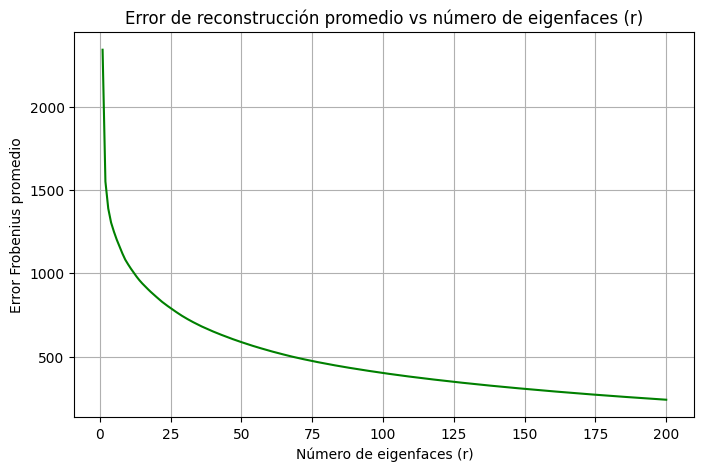

In [16]:
# Graficamos el error de reconstrucción
plt.figure(figsize=(8,5))
plt.plot(rs, errores_recon, color='green')
plt.title("Error de reconstrucción promedio vs número de eigenfaces (r)")
plt.xlabel("Número de eigenfaces (r)")
plt.ylabel("Error Frobenius promedio")
plt.grid(True)
plt.show()

## **PART II: Neural Networks**



*   Modify the example on Convolutional Neural Networks shown in the practical sessions, to use the original MNIST dataset. Create and train all models shown, and plot their convergence curves.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd

En este trabajo se implementan cuatro variantes del modelo LeNet-5 para clasificación de dígitos manuscritos utilizando el conjunto de datos MNIST. Se compararán técnicas de regularización: Dropout, Batch Normalization y Weight Decay.

In [18]:
# Semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [19]:
# Definimos el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [20]:
# Número de clases
num_classes = 10

# Cargar los datos de entrenamiento y prueba
mnist_train = datasets.MNIST(
    "/content/sample_data", download=True, train=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "/content/sample_data", train=False, transform=transforms.ToTensor()
)

# Crear DataLoaders para las batches
train_data = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_data = DataLoader(mnist_test, batch_size=128, shuffle=False)

# Verificar tamaños
len_train, len_test = len(mnist_train), len(mnist_test)
print(f"Ejemplos de entrenamiento: {len_train} | Ejemplos de prueba: {len_test}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]

Ejemplos de entrenamiento: 60000 | Ejemplos de prueba: 10000


El conjunto de datos MNIST contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba de dígitos manuscritos (0-9) en escala de grises de 28×28 píxeles. Las imágenes se convierten a tensores mediante transforms.ToTensor(), que automáticamente normaliza los valores de píxeles al rango [0, 1].

Se utilizan DataLoader con un tamaño de batch de 128 para optimizar el entrenamiento mediante procesamiento por lotes. El parámetro shuffle=True en el conjunto de entrenamiento asegura que los datos se mezclen en cada época, mejorando la generalización del modelo.

### Arquitectura de los Modelos

Se implementan cuatro variantes del modelo LeNet-5, cada una diseñada para evaluar diferentes técnicas de regularización:

##### Modelo Base (LeNet-5)
Arquitectura clásica propuesta por Yann LeCun:
- **Capa 1**: Convolución (1→6 canales, kernel 5×5) + Tanh + Average Pooling
- **Capa 2**: Convolución (6→16 canales, kernel 5×5) + Tanh + Average Pooling  
- **Capas fully connected**: 400→120→84→10
- **Función de activación**: Tanh (como en la arquitectura original)

In [21]:
import torch.nn as nn
class LeNet5Base(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

#### Modelo con Dropout
Incorpora una capa de Dropout con probabilidad 0.5 después de las capas convolucionales para prevenir overfitting mediante la desactivación aleatoria de neuronas durante el entrenamiento.

In [22]:
class LeNet5Dropout(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.drop_layer = nn.Dropout(0.5)  # Dropout layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.drop_layer(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

#### Modelo con Batch Normalization
Añade capas de Batch Normalization después de cada convolución para normalizar las activaciones, acelerando la convergencia y estabilizando el entrenamiento.

In [23]:
class LeNet5BatchNorm(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

#### Modelo con Weight Decay
Arquitectura idéntica al modelo base, pero con regularización L2 aplicada mediante el parámetro `weight_decay=0.001` en el optimizador. Esta técnica penaliza los pesos grandes para reducir el overfitting.

In [24]:
import torch.nn as nn
class LeNet5WeightDecay(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

### Entrenamiento de los Modelos

Se define una función genérica `train_and_evaluate()` para estandarizar el proceso de entrenamiento de todos los modelos. Esta función:

1. **Entrenamiento**: Calcula el forward pass, pérdida, backpropagation y actualización de pesos
2. **Evaluación**: Mide la precisión en el conjunto de prueba sin calcular gradientes (`torch.no_grad()`)
3. **Métricas**: Registra la precisión de entrenamiento y prueba en cada época

Se utiliza:
- **Función de pérdida**: CrossEntropyLoss (combina LogSoftmax y NLLLoss)
- **Optimizador**: Adam con learning rate de 0.002
- **Número de épocas**: 8
- **Batch size**: 128

Todos los modelos comparten los mismos hiperparámetros para asegurar una comparación:

In [25]:
# generalizando --> función para entrenar y evaluar los modelos
def train_and_evaluate(model, train_data, test_data, loss_function, optimizer, num_epochs=8):
    train_accuracy = []
    test_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Evaluación del modelo
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_data:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        train_accuracy.append(100 * train_correct / train_total)
        test_accuracy.append(100 * test_correct / test_total)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accuracy[-1]:.4f} | Test Acc: {test_accuracy[-1]:.4f}")

    return train_accuracy, test_accuracy

In [26]:
# Parámetro
learn_rate = 0.002

# Modelo base
print("Modelo base")
model_base = LeNet5Base(num_classes).to(device)
optimizer_base = optim.Adam(model_base.parameters(), lr = learn_rate)
loss_function = nn.CrossEntropyLoss()
train_accuracy_base, test_accuracy_base = train_and_evaluate(model_base, train_data, test_data, loss_function, optimizer_base)

# Modelo con Dropout
print("Modelo con Dropout")
model_dropout = LeNet5Dropout(num_classes).to(device)
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr = learn_rate)
train_accuracy_dropout, test_accuracy_dropout = train_and_evaluate(model_dropout, train_data, test_data, loss_function, optimizer_dropout)

# Modelo con Batch Normalization
print("Modelo con Batch Normalization")
model_batch_norm = LeNet5BatchNorm(num_classes).to(device)
optimizer_batch_norm = optim.Adam(model_batch_norm.parameters(), lr = learn_rate)
train_accuracy_batch_norm, test_accuracy_batch_norm = train_and_evaluate(model_batch_norm, train_data, test_data, loss_function, optimizer_batch_norm)

# Modelo con Weight Decay
print("Modelo con Weight Decay")
model_weight_decay = LeNet5WeightDecay(num_classes).to(device)
optimizer_weight_decay = optim.Adam(model_weight_decay.parameters(), lr = learn_rate, weight_decay=0.001)
train_accuracy_weight_decay, test_accuracy_weight_decay = train_and_evaluate(model_weight_decay, train_data, test_data, loss_function, optimizer_weight_decay)


Modelo base
Epoch 1/8 | Train Acc: 91.5300 | Test Acc: 96.1800
Epoch 2/8 | Train Acc: 97.3050 | Test Acc: 97.5800
Epoch 3/8 | Train Acc: 98.1767 | Test Acc: 98.3800
Epoch 4/8 | Train Acc: 98.5300 | Test Acc: 98.6300
Epoch 5/8 | Train Acc: 98.8750 | Test Acc: 98.5300
Epoch 6/8 | Train Acc: 99.0167 | Test Acc: 98.4300
Epoch 7/8 | Train Acc: 99.1533 | Test Acc: 98.4700
Epoch 8/8 | Train Acc: 99.3283 | Test Acc: 97.9000
Modelo con Dropout
Epoch 1/8 | Train Acc: 88.8850 | Test Acc: 96.0200
Epoch 2/8 | Train Acc: 94.8483 | Test Acc: 97.1600
Epoch 3/8 | Train Acc: 96.2067 | Test Acc: 97.8100
Epoch 4/8 | Train Acc: 96.9883 | Test Acc: 97.9700
Epoch 5/8 | Train Acc: 97.2633 | Test Acc: 98.0900
Epoch 6/8 | Train Acc: 97.4300 | Test Acc: 98.4100
Epoch 7/8 | Train Acc: 97.6783 | Test Acc: 98.4800
Epoch 8/8 | Train Acc: 97.8467 | Test Acc: 98.6200
Modelo con Batch Normalization
Epoch 1/8 | Train Acc: 94.4467 | Test Acc: 97.9300
Epoch 2/8 | Train Acc: 98.1133 | Test Acc: 98.5400
Epoch 3/8 | Train Ac

### Visualización

Las curvas de convergencia muestran la evolución de la precisión en entrenamiento y prueba a lo largo de las épocas. La comparación visual permite identificar:
- **Overfitting**: Cuando la precisión de entrenamiento supera significativamente a la de prueba
- **Underfitting**: Cuando ambas precisiones permanecen bajas
- **Convergencia**: La estabilización de las métricas
- **Efecto de regularización**: Reducción del gap entre entrenamiento y prueba

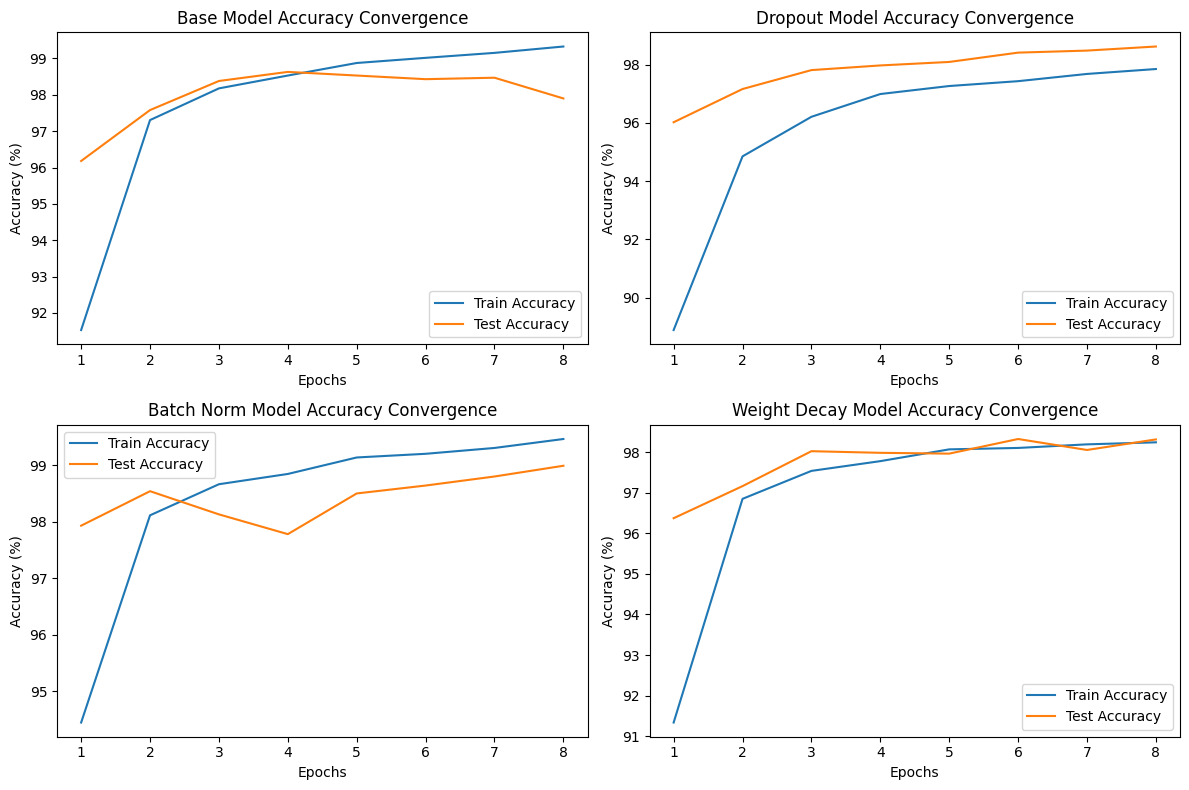

In [27]:
# Graficar las curvas de convergencia

epochs = range(1, 9)
plt.figure(figsize=(12, 8))

# Subplot 1: Base Model
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy_base, label="Train Accuracy")
plt.plot(epochs, test_accuracy_base, label="Test Accuracy")
plt.title("Base Model Accuracy Convergence")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

# Subplot 2: Dropout Model
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy_dropout, label="Train Accuracy")
plt.plot(epochs, test_accuracy_dropout, label="Test Accuracy")
plt.title("Dropout Model Accuracy Convergence")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

# Subplot 3: Batch Norm Model
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracy_batch_norm, label="Train Accuracy")
plt.plot(epochs, test_accuracy_batch_norm, label="Test Accuracy")
plt.title("Batch Norm Model Accuracy Convergence")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

# Subplot 4: Weight Decay Model
plt.subplot(2, 2, 4)
plt.plot(epochs, train_accuracy_weight_decay, label="Train Accuracy")
plt.plot(epochs, test_accuracy_weight_decay, label="Test Accuracy")
plt.title("Weight Decay Model Accuracy Convergence")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# Guardar los modelos entrenados
torch.save(model_base, "model_base.pt")
torch.save(model_dropout, "model_dropout.pt")
torch.save(model_batch_norm, "model_batch_norm.pt")

Los modelos entrenados se guardan utilizando torch.save() para permitir su reutilización posterior sin necesidad de reentrenar. Esto es especialmente útil para inferencia o transferencia de aprendizaje.

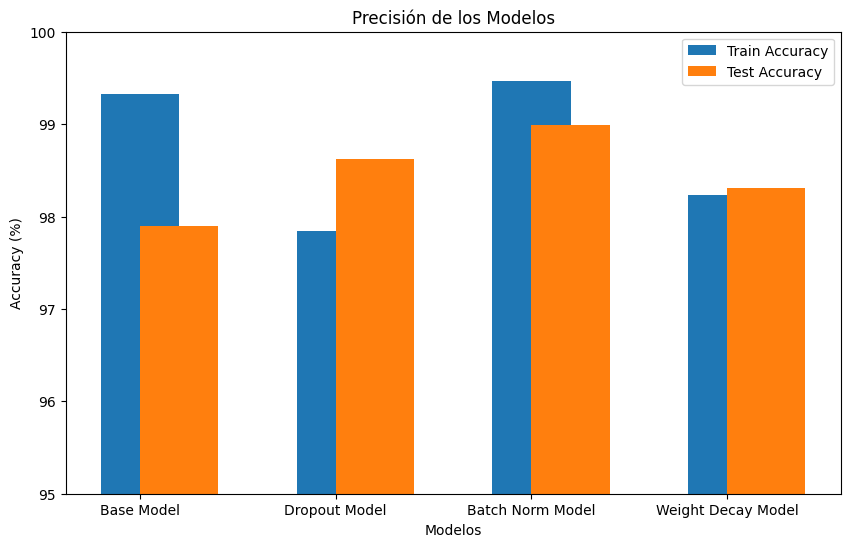

In [28]:
# Obtener precisión final de cada modelo
final_train_accuracy = [
    train_accuracy_base[-1],
    train_accuracy_dropout[-1],
    train_accuracy_batch_norm[-1],
    train_accuracy_weight_decay[-1]
]

final_test_accuracy = [
    test_accuracy_base[-1],
    test_accuracy_dropout[-1],
    test_accuracy_batch_norm[-1],
    test_accuracy_weight_decay[-1]
]

model_labels = ['Base Model', 'Dropout Model', 'Batch Norm Model', 'Weight Decay Model']

# Graficar
plt.figure(figsize=(10, 6))
x = range(len(model_labels))

plt.bar(x, final_train_accuracy, width=0.4, label='Train Accuracy', align='center', alpha=1)
plt.bar(x, final_test_accuracy, width=0.4, label='Test Accuracy', align='edge', alpha=1)

plt.xticks(x, model_labels)
plt.title("Precisión de los Modelos")
plt.ylabel("Accuracy (%)")
plt.xlabel("Modelos")
plt.ylim([95,100])
plt.legend()

plt.show()

In [29]:
# nombres de los modelos
model_names = ["Base", "Dropout", "Weight Decay", "Batch Normalization"]

# Precisiones finales de entrenamiento y prueba
final_train_accuracies = [
    train_accuracy_base[-1],
    train_accuracy_dropout[-1],
    train_accuracy_weight_decay[-1],
    train_accuracy_batch_norm[-1]
]

final_test_accuracies = [
    test_accuracy_base[-1],
    test_accuracy_dropout[-1],
    test_accuracy_weight_decay[-1],
    test_accuracy_batch_norm[-1]
]


summary_table = pd.DataFrame({
    "Model": model_names,
    "Training Accuracy (%)": final_train_accuracies,
    "Testing Accuracy (%)": final_test_accuracies
})

summary_table

,Model,Training Accuracy (%),Testing Accuracy (%)
0,Base,99.328333,97.90
1,Dropout,97.846667,98.62
2,Weight Decay,98.238333,98.31
3,Batch Normalization,99.463333,98.99


La tabla resume el desempeño final de cada modelo después de completar las ocho épocas de entrenamiento, permitiendo una comparación cuantitativa exhaustiva de las diferentes técnicas de regularización implementadas. Es importante destacar que todas las variantes del modelo LeNet-5 fueron entrenadas bajo condiciones idénticas, incluyendo el mismo learning rate de 0.002, el optimizador Adam, y el tamaño de batch de 128 imágenes, lo cual garantiza que las diferencias observadas en el rendimiento sean atribuibles exclusivamente a las técnicas de regularización aplicadas y no a variaciones en los hiperparámetros de entrenamiento. Las métricas presentadas corresponden específicamente a la última época, momento en el cual los modelos han tenido suficiente tiempo para converger y estabilizar su desempeño. La precisión de entrenamiento refleja qué tan bien el modelo ha aprendido a clasificar los datos con los que fue entrenado, mientras que la precisión de prueba constituye un indicador más confiable de la capacidad de generalización del modelo, es decir, su habilidad para clasificar correctamente dígitos que no ha visto durante el entrenamiento. La brecha entre estas dos métricas, conocida como gap de generalización, es particularmente reveladora del nivel de sobreajuste presente en cada arquitectura.



*   Written Commentary



Los resultados experimentales obtenidos proporcionan evidencia empírica significativa sobre el impacto diferenciado que cada técnica de regularización ejerce sobre el proceso de aprendizaje y la capacidad de generalización de las redes neuronales convolucionales. El modelo que incorpora Dropout demuestra su efectividad en la reducción del overfitting mediante un mecanismo estocástico que desactiva aleatoriamente neuronas durante el entrenamiento con una probabilidad del cincuenta por ciento. Este proceso obliga a la red a desarrollar representaciones más robustas y distribuidas, evitando que las neuronas co-adapten excesivamente sus pesos a patrones específicos del conjunto de entrenamiento. La naturaleza aleatoria de Dropout actúa como un método de ensamble implícito, donde cada paso de entrenamiento efectivamente entrena una sub-red diferente, y durante la inferencia se promedia el efecto de todas estas sub-redes, resultando en predicciones más estables y confiables.

Por otro lado, la técnica de Batch Normalization introduce un mecanismo fundamentalmente diferente al normalizar las activaciones de cada mini-batch, reduciendo el problema conocido como Internal Covariate Shift, donde las distribuciones de las activaciones de las capas intermedias cambian durante el entrenamiento. Al estandarizar estas activaciones para que tengan media cero y varianza unitaria antes de aplicar la función de activación, Batch Normalization permite utilizar tasas de aprendizaje más altas sin riesgo de divergencia, acelera significativamente la convergencia del modelo, y proporciona un efecto regularizador moderado que puede, en algunos casos, reducir la necesidad de otras técnicas como Dropout. Además, esta técnica hace que el entrenamiento sea menos sensible a la inicialización de pesos, proporcionando mayor estabilidad numérica a lo largo del proceso de optimización.

La regularización L2 implementada a través del parámetro Weight Decay en el optimizador Adam representa un enfoque clásico y matemáticamente elegante para controlar la complejidad del modelo. Esta técnica añade un término de penalización proporcional a la magnitud cuadrática de los pesos a la función de pérdida, lo que efectivamente desalienta al modelo de desarrollar pesos extremadamente grandes que podrían indicar memorización de ruido en los datos de entrenamiento. El efecto práctico es que los pesos tienden a permanecer pequeños a menos que exista evidencia fuerte en los datos que justifique valores mayores, promoviendo soluciones más simples y generalizables en línea con el principio de parsimonia de Occam. Esta regularización es particularmente efectiva cuando se combina con optimizadores adaptativos como Adam, aunque requiere un ajuste cuidadoso del coeficiente de decay para balancear entre underfitting y overfitting.

Para determinar cuál modelo exhibe la mejor capacidad de generalización, es necesario analizar tres criterios fundamentales de manera conjunta y no aislada. El primer criterio es la precisión absoluta en el conjunto de prueba, que indica directamente qué tan bien el modelo puede clasificar datos nunca antes vistos, representando la métrica más importante en aplicaciones prácticas de machine learning. El segundo criterio, igualmente crucial, es el gap de generalización, definido como la diferencia entre la precisión de entrenamiento y la precisión de prueba. Un gap pequeño sugiere que el modelo ha aprendido patrones genuinos y transferibles en lugar de simplemente memorizar los datos de entrenamiento, mientras que un gap grande es síntoma inequívoco de overfitting severo. Finalmente, el tercer criterio implica examinar la estabilidad de la convergencia a lo largo de las épocas, observando si las curvas de precisión muestran un comportamiento suave y monotónicamente creciente o si, por el contrario, presentan oscilaciones erráticas que podrían indicar inestabilidad en el proceso de optimización o sensibilidad excesiva a variaciones aleatorias en los mini-batches. Un modelo verdaderamente robusto y bien regularizado debería alcanzar alta precisión en prueba, mantener un gap de generalización mínimo, y demostrar una trayectoria de convergencia estable y predecible que inspire confianza en su despliegue en entornos de producción.